In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [14]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [15]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [16]:
data.tail()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,2.81,3.08,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,2.84,3.12,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,2.87,3.15,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,2.84,3.14,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,2.91,3.22,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7931 non-null object
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null object
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(6), object(2)
memory usage: 557.6+ KB


In [18]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [19]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [20]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [128]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [129]:
data.columns
#values = data[['exukus'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
#values = values.astype('float32')

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [130]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [131]:
values

array([[2.78210e+02, 8.05000e+00, 8.92000e+00, ..., 1.38200e+00,
        1.39780e+02, 5.94200e-01],
       [2.80170e+02, 8.06000e+00, 8.87000e+00, ..., 1.38640e+00,
        1.40450e+02, 5.95600e-01],
       [2.82160e+02, 7.97000e+00, 8.78000e+00, ..., 1.38830e+00,
        1.40600e+02, 5.97700e-01],
       ...,
       [2.71174e+03, 2.87000e+00, 3.15000e+00, ..., 1.41040e+00,
        1.12860e+02, 7.82500e-01],
       [2.74037e+03, 2.84000e+00, 3.14000e+00, ..., 1.39100e+00,
        1.12790e+02, 7.70800e-01],
       [2.72306e+03, 2.91000e+00, 3.22000e+00, ..., 1.38910e+00,
        1.13090e+02, 7.71300e-01]], dtype=float32)

In [132]:
look_back = 3 
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
7926,2656.100098,2.84,3.10,77.339996,1230.550049,1.4140,112.580002,0.7753,2705.570068,2.86,...,111.650002,0.7797,2641.250000,2.81,3.08,77.559998,1230.800049,1.4136,112.489998,0.7808
7927,2705.570068,2.86,3.14,77.300003,1230.800049,1.4116,112.540001,0.7796,2658.689941,2.81,...,112.489998,0.7808,2682.629883,2.84,3.12,75.680000,1225.400024,1.4061,112.760002,0.7855
7928,2658.689941,2.81,3.08,77.400002,1233.849976,1.4108,111.650002,0.7797,2641.250000,2.81,...,112.760002,0.7855,2711.739990,2.87,3.15,74.839996,1214.949951,1.4104,112.860001,0.7825
7929,2641.250000,2.81,3.08,77.559998,1230.800049,1.4136,112.489998,0.7808,2682.629883,2.84,...,112.860001,0.7825,2740.370117,2.84,3.14,71.250000,1231.150024,1.3910,112.790001,0.7708
7930,2682.629883,2.84,3.12,75.680000,1225.400024,1.4061,112.760002,0.7855,2711.739990,2.87,...,112.790001,0.7708,2723.060059,2.91,3.22,71.110001,1232.099976,1.3891,113.089996,0.7713


In [133]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [134]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [135]:
# train_t = scaler.inverse_transform(test)
# train_t[-1]

In [136]:
# split into input and outputs
train_X, train_y = train[:, :-8], train[:, -8:]
test_X, test_y = test[:, :-8], test[:, -8:]

In [137]:
train_X.shape

(5068, 24)

In [138]:
train_y.shape

(5068, 8)

In [139]:
train_X = train_X.reshape((train_X.shape[0], 3, 8))
test_X = test_X.reshape((test_X.shape[0], 3, 8))
#train_y = train_y.reshape((train_y.shape[0], 1, train_y.shape[1]))
#test_y = test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5068, 3, 8) (5068, 8) (2173, 3, 8) (2173, 8)


# Building the Model

In [140]:
model = Sequential()

model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=100))
#model.add(Dropout(0.2))
#model.add(LSTM(units=100, return_sequences=True))
#model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(
    250,
    return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(8 , activation='linear'))

from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('market_lstm_modelv3')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]


model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 3, 100)            43600     
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 250)               351000    
_________________________________________________________________
dropout_12 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2008      
Total params: 396,608
Trainable params: 396,608
Non-trainable params: 0
_________________________________________________________________


In [141]:
n_batch = 100
history = model.fit(train_X, train_y, epochs=50, batch_size=n_batch, validation_data=(test_X, test_y), callbacks = callbacks_list)

Train on 5068 samples, validate on 2173 samples
Epoch 1/50
5068/5068 [==============================] - 4s 794us/step - loss: 0.0387 - val_loss: 0.0530

Epoch 00001: val_loss improved from inf to 0.05302, saving model to market_lstm_modelv3_weights.hdf5
Epoch 2/50
5068/5068 [==============================] - 1s 232us/step - loss: 0.0057 - val_loss: 0.0329

Epoch 00002: val_loss improved from 0.05302 to 0.03285, saving model to market_lstm_modelv3_weights.hdf5
Epoch 3/50
5068/5068 [==============================] - 1s 235us/step - loss: 0.0032 - val_loss: 0.0180

Epoch 00003: val_loss improved from 0.03285 to 0.01800, saving model to market_lstm_modelv3_weights.hdf5
Epoch 4/50
5068/5068 [==============================] - 1s 233us/step - loss: 0.0024 - val_loss: 0.0155

Epoch 00004: val_loss improved from 0.01800 to 0.01553, saving model to market_lstm_modelv3_weights.hdf5
Epoch 5/50
5068/5068 [==============================] - 1s 235us/step - loss: 0.0021 - val_loss: 0.0132

Epoch 00005

5068/5068 [==============================] - 1s 233us/step - loss: 7.0987e-04 - val_loss: 7.6649e-04

Epoch 00044: val_loss did not improve from 0.00061
Epoch 45/50
5068/5068 [==============================] - 1s 229us/step - loss: 7.0941e-04 - val_loss: 7.2697e-04

Epoch 00045: val_loss did not improve from 0.00061
Epoch 46/50
5068/5068 [==============================] - 1s 230us/step - loss: 6.9497e-04 - val_loss: 6.6055e-04

Epoch 00046: val_loss did not improve from 0.00061
Epoch 47/50
5068/5068 [==============================] - 1s 229us/step - loss: 6.7907e-04 - val_loss: 7.7246e-04

Epoch 00047: val_loss did not improve from 0.00061
Epoch 48/50
5068/5068 [==============================] - 1s 231us/step - loss: 6.8099e-04 - val_loss: 7.6253e-04

Epoch 00048: val_loss did not improve from 0.00061
Epoch 49/50
5068/5068 [==============================] - 1s 234us/step - loss: 6.7021e-04 - val_loss: 7.5962e-04

Epoch 00049: val_loss did not improve from 0.00061
Epoch 50/50
5068/5068 

In [134]:
# multi_model = Sequential()
# multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
# multi_model.add(Dense(1))
# multi_model.compile(loss='mae', optimizer='adam')

# Callbacks
# from keras.callbacks import ModelCheckpoint

# weight_path="{}_weights.hdf5".format('market_lstm_model')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = False)
# callbacks_list = [checkpoint]


# multi_history = multi_model.fit(train_X, train_y, epochs=40, batch_size=150, validation_data=(test_X, test_y), 
#                                 verbose=1, shuffle=False)#, callbacks = callbacks_list)

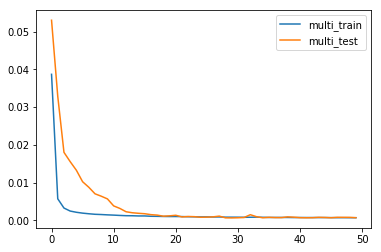

In [142]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [143]:
yhat = model.predict(test_X)

In [144]:
test_y.shape

(2173, 8)

In [145]:
yhat.shape

(2173, 8)

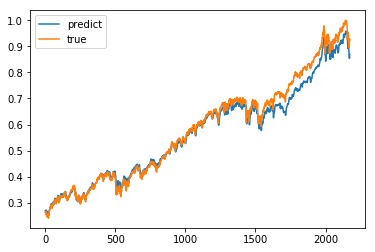

In [146]:
#pyplot.plot(yhat[:,0][:,0], label='predict')
#pyplot.plot(test_y[:,0][:,0], label='true')
pyplot.plot(yhat[:,0], label='predict')
pyplot.plot(test_y[:,0], label='true')
pyplot.legend()
pyplot.show()

In [147]:
test_X.shape

(2173, 3, 8)

In [148]:
test_X.shape

(2173, 3, 8)

In [149]:
#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

#yhat.shape

#yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

#test_X.shape

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

#inv_yhat.shape

inv_yhat = scaler.inverse_transform(inv_yhat)

#inv_yhat[:,-8:].shape

inv_yhat = inv_yhat[:,-8:]

#inv_yhat.shape

In [150]:
test_y.shape

(2173, 8)

In [151]:
inv_y = concatenate((test_X[:, :], test_y), axis=1)

#inv_y.shape

inv_y = scaler.inverse_transform(inv_y)

inv_y[:,-8:].shape

inv_y = inv_y[:,-8:]

#inv_y.shape

In [152]:
rmse = sqrt(mean_squared_error(test_y[:,0], yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.027


In [153]:
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 74.104


In [157]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,3], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,3], name= 'Multi Predict Price')
py.iplot([multi_predict_chart, actual_chart])